## 1. Setup Environment

In [1]:
## This is a Juptyer notebook for the Kaggle dataset:brain-tumor-detection

# %pip install -q -U keras-tuner
# %pip install torch
# %pip install torchvision
# %pip install tensorflow
# %pip install -U segmentation-models
# %pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch
# %pip install -U -q segmentation-models
# %pip install -q tensorflow==2.2.1
# %pip install -q keras==2.5
# %pip install pydot
# %pip install pillow
%pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import the necessary packages
import seaborn as sns
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
import keras
import torch
import glob
import torchvision
import pathlib
from tqdm import tqdm
import segmentation_models as sm
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler, CSVLogger

# Download the pretrained models to use in the transfer learning
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, MobileNetV2, NASNetLarge, Xception, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

from skimage.io import imread
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from PIL import ImageFont

import warnings
warnings.filterwarnings("ignore")

# Seeding 
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_seed(42)


Segmentation Models: using `tf.keras` framework.


C:\Users\Kai Qi Yan\AppData\Local\Temp\ipykernel_184\2104237154.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


## 2. Problem identification

This is a <b>instance image classification problem </b> of brain tumor with the dataset available in https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri.

The dataset consist of MRI images of brain with different stages of tumor, namely: 
no_tumor, pituitary_tumor, glioma_tumor, and meningiomma_tumor, separated into a training set and a testing set. 

The pituitary tumor, glioma tumor, and meningiomma tumor, are tumors locating in different origins of the brain. 
- <b> Pituitary Tumor</b>: These are tumors developed in the pituitary gland, a small gland located at the base of the brain.
- <b> Glioma Tumor </b>: These are tumors originate from glial cells, which are supportive cells in the brain and spinal cord.
- <b> Meningioma Tumor</b>: These are tumors develop in the meninges, the protective layers covering the brain and spinal cord.

The objective of this project is to build a classifier that can correctly classfy the stages of brain tumor based on the MRI images. The performance of the classifier will be measured by accuracy of prediction and f1 score om the testing dataset. 



## 3. Importing data

The first task in a project is usually properly reading the data and transform them into a usable format. Because the incoming dataset are not necessaryily formatted in a way that we desired, we may also need to format them to ease the following data analysis. 

Because of the different operating procedures adopted in collecting the data, the structure of the collected data may vary from project to project. For example, in one project the imagerial data are stored according to the patient index; while in other project the imagerial data are classified into different classes prior for the learning. 

In problems with imagerial data, usually we will have imagerial data, metadata (the descriptors of the imagerial data), and might also include masks (if semantic segmantation is required). These data are usually stored in different directory. In order to minimize the effort in locating the files, we should state clearly the expected structure of the directory, and read the files accordiningly. 

<br> To walkthrough the directory, different methods from os or glob can be used. Such as os.walk() and glob.glob.

### 3.1. Reading data and setup of file directory

In [3]:
# Define the data path
path_train = (r'archive\Training')
path_test = (r'archive\Testing')

# Define the image size
img_size= 300

# Defining a function to load the images
def load_images(path, img_size):
    """
    This function loads the images from the path and resizes them to the specified size
    """
    labels = []
    img_list = []
    for i in os.listdir(path):
        dir_path = os.path.join(path, i)  # Use os.path.join for correct path construction
        for j in os.listdir(dir_path):
            img_path = os.path.join(dir_path, j)
            img = cv2.imread(img_path)
            if img is not None:
                resized_img = cv2.resize(img, (img_size, img_size))
                img_list.append(resized_img)
                labels.append(i)
            else:
                print(f"Failed to load image: {img_path}") 
    return img_list, labels

# Load the training images
train_img, train_labels = load_images(path_train, img_size)

# Load the testing images
test_img, test_labels = load_images(path_test, img_size)

# Convert the images to numpy arrays
train_img = np.array(train_img)
test_img = np.array(test_img)

### 3.2. Data Inspection
After reading the files, we can have a look on the imported data to ensure the images are read correctly. We can confirm the size of the imagerial dataset, as well as confiming the number of pixels and the number of color channels in them.  

#### 3.2 a. Shape of the dataset and image inspection

In [4]:
# Display the shape of the images
print(f"Train images shape: {train_img.shape}")
print(f"Test images shape: {test_img.shape}")

# Display an image from each of the classes in the training set
unique_labels = np.unique(train_labels)
print(f"Unique labels: {unique_labels}")

Train images shape: (2870, 300, 300, 3)
Test images shape: (394, 300, 300, 3)
Unique labels: ['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


<Figure size 640x480 with 0 Axes>

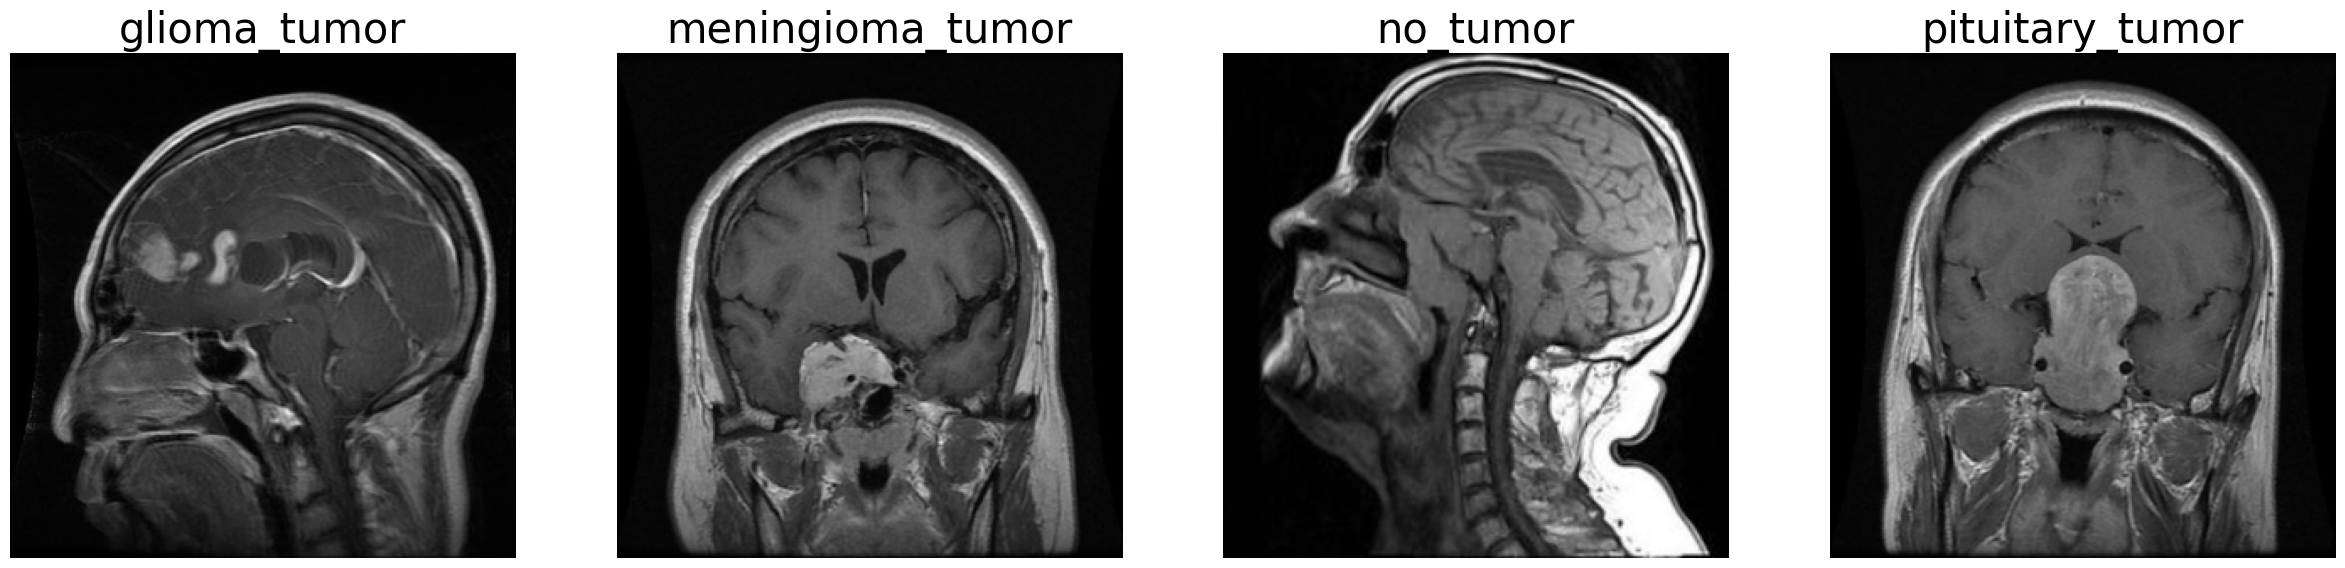

In [5]:
# Adjust subplot parameters to prevent overlap
plt.subplots_adjust(wspace=0.4)  # Adjust the width spacing between subplots

# Set the figure size
plt.figure(figsize=(30, 30))

# Display an image from each of the classes in the training set
for i, label in enumerate(unique_labels):
    matching_indices = [j for j, x in enumerate(train_labels) if x == label]
    if matching_indices:
        random_index = np.random.choice(matching_indices)
        plt.subplot(1, 4, i+1)
        plt.imshow(train_img[random_index])
        plt.title(label, fontsize=30)
        plt.axis('off')
    else:
        print(f"No images found for label {label}")

> From the images, there are images captured in different orientation in each class. This might reduce the model capability in classifying the images. To deal with that, it might be better to further label the images with their orientation, and consider the orientation as a fetaure to learn from the dataset.

#### 3.2 b Distribution of classes in the datasets

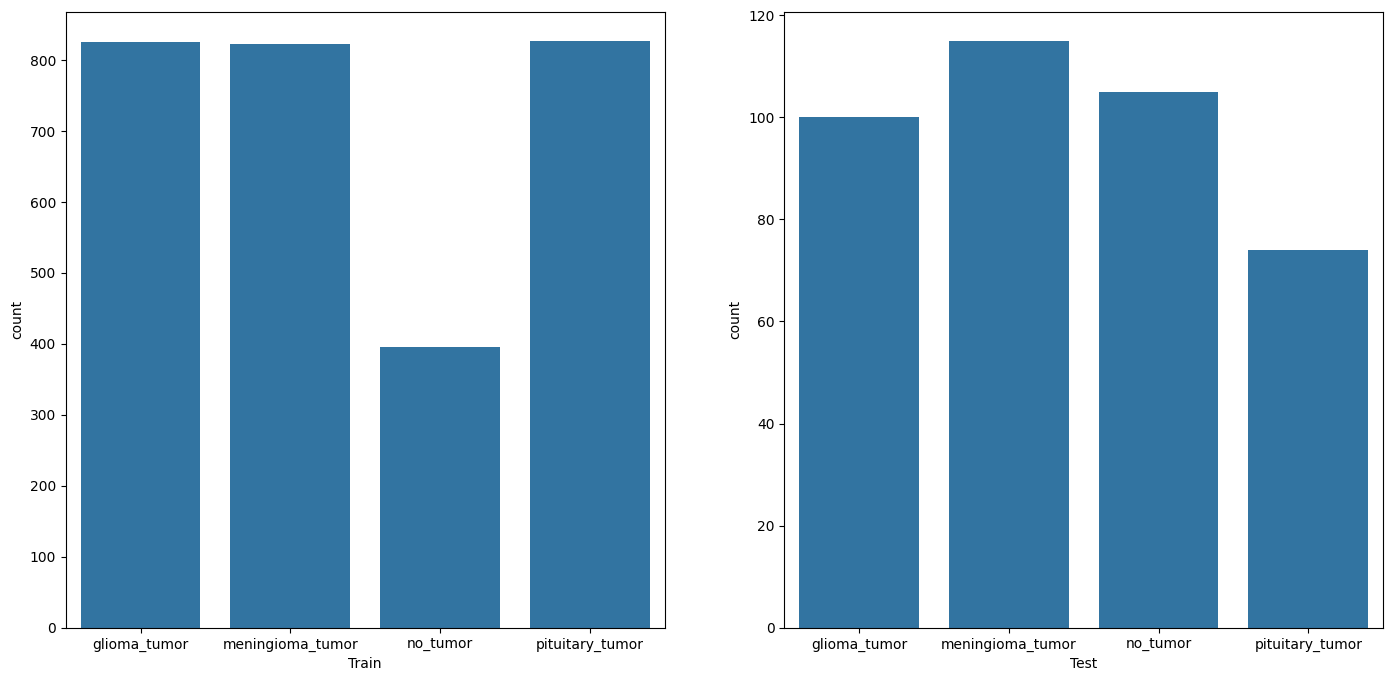

In [6]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

## 4.Feature engineering

In image classification problem, the dataset is usually quite small and therefore it is quite often that we generate more imagerial data from the existing dataset by slightly modifying the data, such as by rotating and zooming the images. For common image augmentation, it is usually done by using the keras.ImageDataGenerator(). 

Other useful packages include:
1. imgaug: for more options in augmenting the images [1]
2. Patchify: for cutting 2D/3D images into smaller patches (patching) or recover a larger image by unpatching them. [2]
3. albumentation: for more options in augmenting the images [3]

<br>References:
<br>[1] https://github.com/aleju/imgaug
<br>[2] https://blog.csdn.net/gitblog_00025/article/details/139384920
<br>[3] https://albumentations.ai/


### 4.1. Generate additional image using the ImageDataGenerator()

In [7]:
img_datagen = ImageDataGenerator(
rotation_range=30,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.2,
horizontal_flip=True
)

### 4.2 Generate additional image by masking random part of the image and applying filters

In this section, some random noise is added to the images to mimic non-ideal images. A function is constructed to create new images with random blurs on the original image. The function applies random blurs, and add the images as well as their labels back to the data arrays.

Filters can be found in different image processing package, such as Pillow [1], and Scipy.ndimage [2]. 

References:
<br> [1]:https://pillow.readthedocs.io/en/latest/handbook/index.html
<br> [2]:https://docs.scipy.org/doc/scipy/reference/ndimage.html 


In [8]:
# ### 4.2 Insert random blurred into the images
# from PIL import Image, ImageFilter, ImageDraw

# def random_blur(X,y, num_blur=3):
#     """
#     This function applies random blurs to the images in the dataset, and returns the new images and labels.
#     """
#     # Convert X and y to lists to allow appending
#     X_list = list(X)
#     y_list = list(y)

#     # Loop through the images
#     for i,img in enumerate (X):

#         # Read the image from an array that contains multiple images
#         img = Image.fromarray(img)

#         # Define the number of blurs
#         num_blur = num_blur

#         # Apply the blurs
#         for _ in range(num_blur): # using _ for indicating the variable is not used in the loop

#         # Generate random positions
#             x = np.random.randint(0,img.size[1])
#             y = np.random.randint(0,img.size[0])

#             # Generate random blur sizes
#             r = np.random.randint(10, 20)

#             # Create a mask for the blurs
#             mask = Image.new('L', img.size, 0)
#             mask_draw = ImageDraw.Draw(mask)
#             mask_draw.ellipse((x-r, y-r, x+r, y+r), fill=255)

#             # Apply the blur
#             blurred = img.filter(ImageFilter.GaussianBlur(radius = np.random.randint(5, 15)))

#             # Paste the blurred image on the original image
#             result=img.paste(blurred, mask=mask) 

#             # Append the blurred image to the list
#             X_list.append(np.array(img)) 
#             y_list.append(y_list[i])

#     # Convert the lists to arrays
#     X = np.array(X_list)
#     y = np.array(y_list)

#     return X, y

# # Apply the random blur function to the training images
# train_img, train_labels = random_blur(train_img, train_labels)

# # Display the shape of the images
# print(f"Train images shape: {train_img.shape}")


In [9]:
# # Display an image from each of the classes in the modified training set
# unique_labels = np.unique(train_labels)
# plt.figure(figsize=(10, 10))
# plt.subplots_adjust(wspace=0.4)  # Adjust the width spacing between subplots
# for i,label in enumerate (unique_labels):
#     plt.subplot(1,len(unique_labels), i+1)
#     plt.imshow(train_img[np.random.choice(np.where(train_labels == label)[0], size=1)[0]])
#     train_img[np.where(train_labels == label)[0][0]]
#     plt.title(label)

## 5. Development of the 1st level models

In this project, we will try a few different models using the CNN architecture. In this project, we will try to implement a CNN model that is developed from scratch, and also two models with backbone using two different pretrained models by transfer learning. 

### 5.0.a Preprocessing of the data

Before defining the models, we will first preprocess the data such as normalize and shuffle them to ease the model training. Note that while some models accept normalized images, some models will have difficulties in accepting the normalized features (e.g. EFFNET).


In [10]:
# Normalize the images
train_img = train_img/255
test_img = test_img/255

# Shuffle the data (Shuffling the data is important as the data is ordered)
from sklearn.utils import shuffle
train_img, train_labels = shuffle(train_img, train_labels, random_state=42)

# Split the training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)


### 5.0.b Some utility functions used in the training of models:

In [11]:
# Hyperparameters of the baseline models
batch_size = 32
alpha = 1e-3
epochs = 20

# Define a function to execute the model
def modelEXE(model_dir,history_dir, model, X_train, y_train, X_val,y_val,epochs=epochs,batch_size=batch_size):
  """
  This function reads the model and history from the directory and returns the model and history if it exists, 
  otherwise it compiles the model and returns the model and history.
  """
  if not os.path.exists(model_dir):

    # Compile the model with cross validation
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    ## Set the checkpoint
    checkpoint = ModelCheckpoint(f"{model_dir}".split('.')[0]+".keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

    ##Set the early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto', restore_best_weights=True)

    ## Instantiate the TensorBoard callback
    # tensorboard = TensorBoard(log_dir = 'logs')

    ## Set the learning rate scheduler  
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)
                              
    # Visualize the model
    # plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    # Data Augmentation
    img_datagen.fit(X_train)

    # Training of the baseline model
    history = model.fit(img_datagen.flow(tf.cast(X_train, tf.float32), np.array(pd.get_dummies(y_train)),shuffle=True), validation_data=(tf.cast(X_val, tf.float32), np.array(pd.get_dummies(y_val))), epochs =epochs, verbose=1, batch_size=batch_size,  callbacks=[early_stopping, checkpoint,reduce_lr])

    # Show the model summary
    model.summary()

    # Store the history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_dir, index=False)
    return model, history_df

  else:
    # load the history
    history_df = pd.read_csv(history_dir)
    model_loaded= tf.keras.models.load_model(model_dir)
    # evaluate the model
    model_loaded.evaluate(tf.cast(X_val, tf.float32), np.array(pd.get_dummies(y_val)))
    return model_loaded, history_df

# Define a function to plot the history
def plot_history(history_df):
    plt.figure(figsize=(15, 5))
    plt.plot(history_df['accuracy'], label='Train Accuracy',color='red')
    plt.plot(history_df['val_accuracy'], '-.', label='Validation Accuracy',color='red')
    plt.plot(history_df['loss'], label='Train Loss',color='blue')
    plt.plot(history_df['val_loss'],'-.', label='Validation Loss',color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')
    plt.legend()
    plt.grid()
    plt.show()

#### 5.1. Baseline model by a simple achitecture 

Here we develope a simple CNN achitecture. A typical CNN consists of multiple layers, with input layer at the top, output layer at the bottom, and multiple convolution, pooling, activation and dense layers in the middle, as the hidden layers. 

- The <b>input layer</b> is the layer where the features goes into the model. The number of neurons in this layer is equale to the number of features. 

- The <b>convolution layers</b> can be regarded as filter layers, which detect and extract features from the input data. The layer extract features by applying a kernel (a matrix with randomly initialized weights) over the entire image (by dot product). The calculation steps are listed in the followings:
1. For a 2D image in RGB, the shape of the image would be (H,W,3).
2. Each kernel in the Conv layer is also 3D, with dimension (kH,kW,3). The depth of the kernal must match the number of input channels. 
3. The kernel slide over the input image defined by the Stride, and perform a dot product multiplication with the patch of the input image at the current location. Such dot product is done across all the three color channels and sum up into a single value, producing a 2D feature map for each kernel. 
4. In a Conv layer, usually multiple kernels will be used. If N kernels are used in a Conv layer, then the output of the Conv layer will have a dimension of (H',W',N).
> Note that the weights of the kernels are learnt from the 

- The <b>pooling layers</b> are added to the Covnets for dimensional reduction, which helps speeding up the train ing and prevents overfitting. Two common types of poolings are Max Pooling and Average Pooling. The dimensions of output after the pooling layer reduced according to the number of stride and the filter size. 

- The <b>Flattening layer</b> turns the resulting feature maps into a 1D vector such that they ccan be passed to the Dense layer for categorization / regression. 

- The <b>Dropout layer</b> is used as a regularization technique for prevent overfitting of the network. During each training iteration, the dropout layer will randomly dropout a set of nerons by setting their input units to 0 at each update. The portion is ddetermined by the defined dropout rate (~0.2-0.5). Then the remaining are scaled up to maintain the expected sum over the inputs. As during each iteration a different set of neurons is dropped, the dropout layer creates a form of ensemble of multiple smaller networks.

- The <b>activation layers</b> add activation functions to the output of the previous layer, and add non-linearity to the network. It will apply an element-wise activation function to the output of the convolution layer. Some common activation functions are RELU: max(0, x), Tanh, Leaky RELU, sigmoid, softmax etc. The dimensions of output after the activation layer will not change.

>   Output = activation (input)

- The <b>dense layer (Fully connected layer)</b>: A layer where each neuron is connected to every neuron in the preceding layer.  This means that the output from each neuron in the previous layer serves as input to each neuron in the Dense layer. Because of their full connectivity, the dense layers are capable to capture complex patterns and interactions in the data. Dense layer can also be used to change the dimensionality of the data. It is usually used to reduce the dimensions of the output for classification/ regression in the last layer of the hidden layer.

    The Dense layer performs a linear transformation followed by an activation function (optional). Mathematically, it can be expressed as: 

>   Output = activation (dot(input,kernel))

- The <b>Output Layer</b>: The output from the fully connected layers is then fed into a logistic function for classification tasks like sigmoid or softmax which converts the output of each class into the probability score of each class. The Output layer is usually a Dense layer with logistic activation function such as softmax or sigmoid.

References:
<br> [1] https://geeksforgeeks.org/introduction-convolution-neural-network/
<br> [2] https://carpentries-incubator.github.io/intro-image-classification-cnn/instructor/03-build-cnn.html 


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.8454 - loss: 0.4605


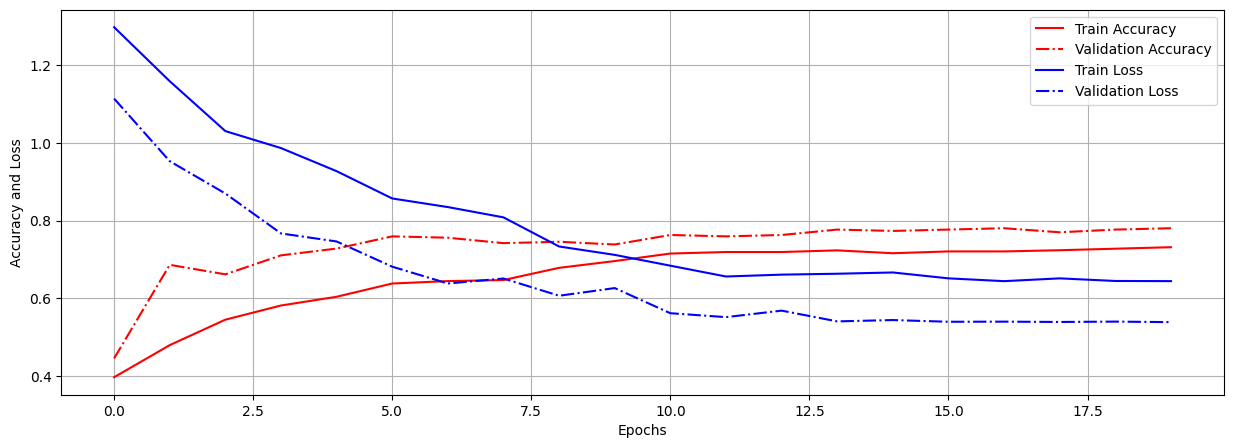

In [12]:
from keras.utils import plot_model
import visualkeras

# 5.1.a Define a directory to save the model
model_1_dir = 'model_1.keras'
history_1_dir = 'history_1.csv'

# 5.1.b Define the model architecture
model_1 = tf.keras.Sequential(
    [
      tf.keras.layers.Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same',input_shape=(img_size, img_size, 3)),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),

      tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),

      tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),

      tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(4, activation='sigmoid')
  ])

# 5.1.c Execute the model
model_1, history_1 = modelEXE(model_1_dir, history_1_dir, model_1, X_train, y_train, X_val, y_val)

# 5.1.d Plot the history
plot_history(history_1)

(-0.5, 645.5, 444.5, -0.5)

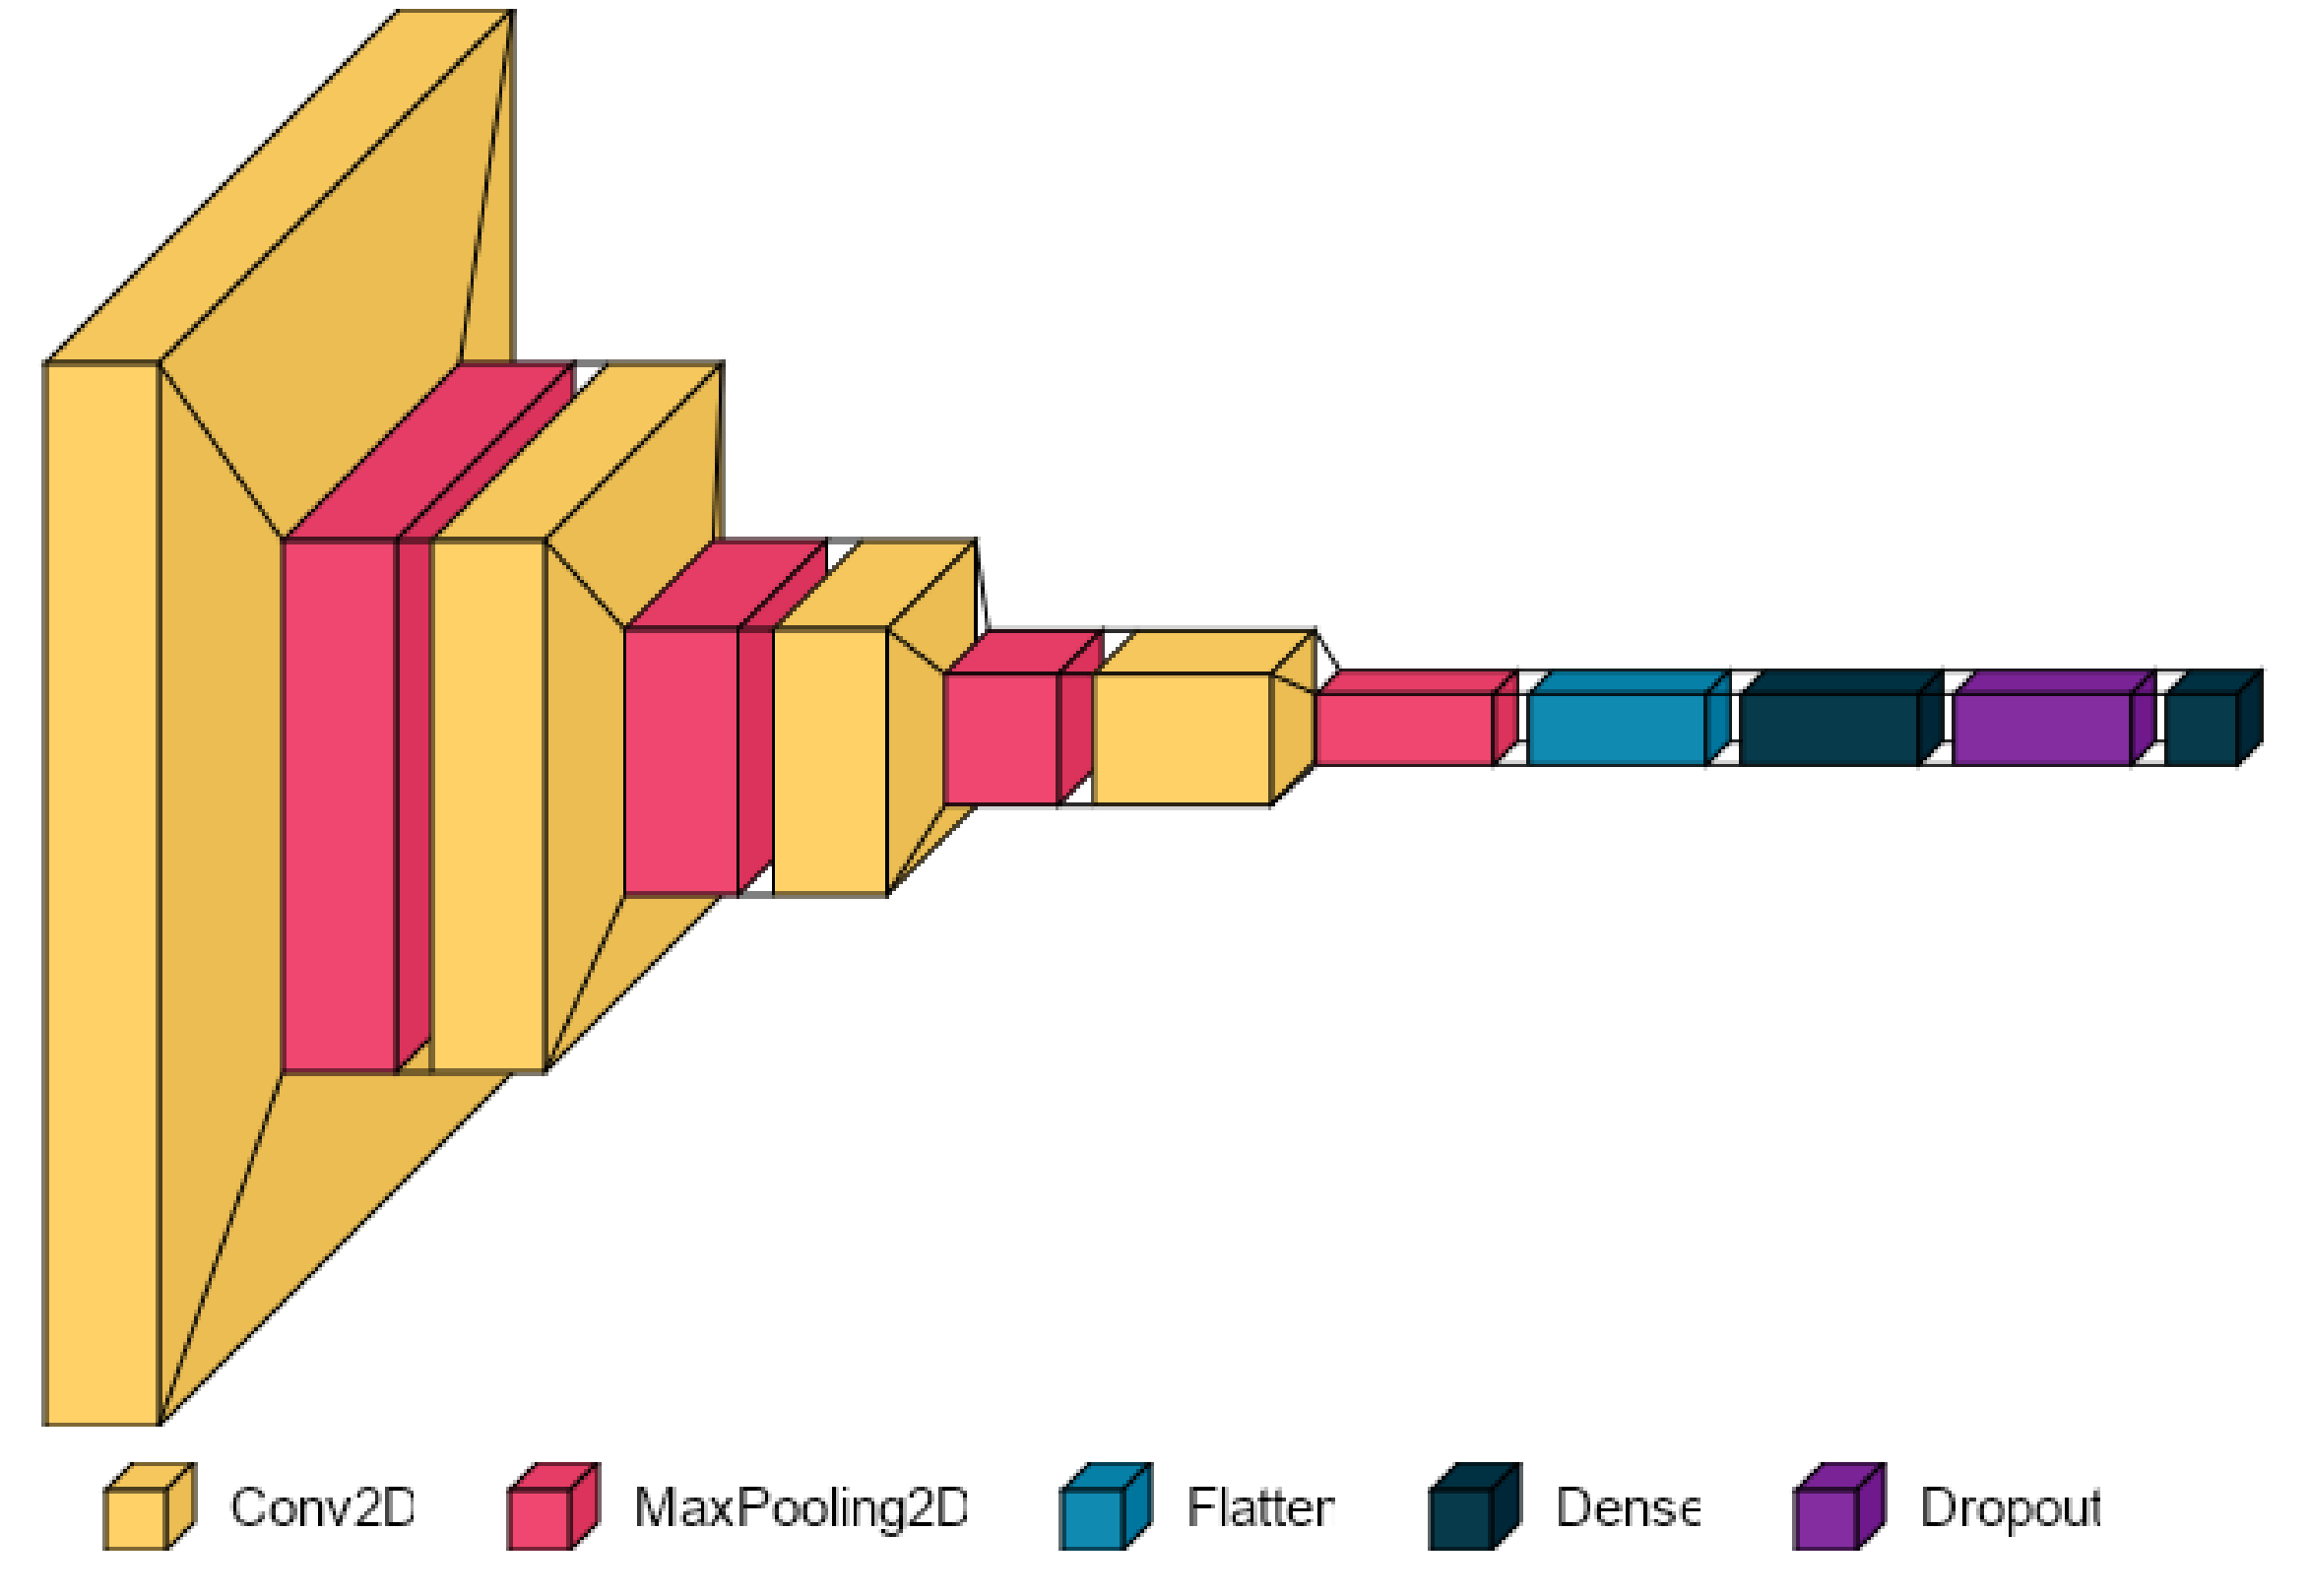

In [13]:
# 5.1.e Visualize the model
font = ImageFont.truetype("arial.ttf", 15)  
visualkeras.layered_view(model_1, to_file='SimpleCNN.png', legend=True,font=font, scale_xy=1, scale_z=1, max_z=50)
# Display the image
plt.figure(figsize=(30,30))
plt.imshow(plt.imread('SimpleCNN.png'))
plt.axis('off')

### 5.2. Model with transfer learning using VGG 16

Next, two different models pretrained with Imagenet, the VGG16 and EfficientNetB0 are used for transfer learning. In transfer learning, pretrained model is used as the initial layer. These models are usually trained with vast image datasets such that they are capable in extracting features. As different images usually have some features in common (such as some strokes or patterns), we can use these pretrained models as the top layer for the training of a model that can classify images in our applications.

9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.8481 - loss: 0.4019


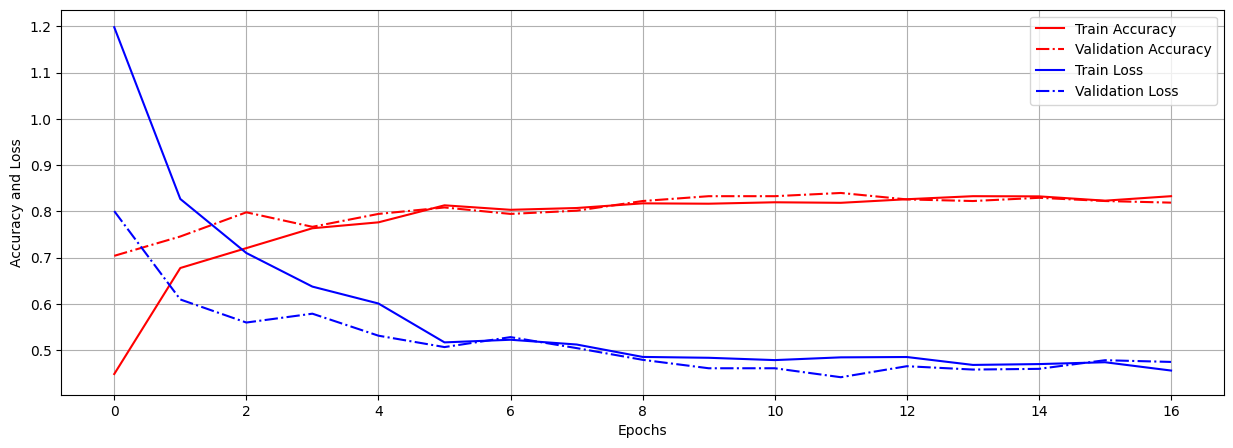

In [14]:
#5.2.a Define a directory to save the model
model_2_dir = 'model_2.keras'
history_2_dir = 'history_2.csv'

#5.2.b Define the model by transfer learning model using VGG16

## Load the VGG16 model
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

## Make sure the base model is not trainable
VGG16_base.trainable = False

## Additional layers
model_2 = VGG16_base.output
model_2 = tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same')(model_2)
model_2 = tf.keras.layers.GlobalAveragePooling2D()(model_2)

model_2 = tf.keras.layers.Dense(128, activation='relu')(model_2)
model_2 = tf.keras.layers.Dropout(rate=0.5)(model_2)
model_2 = tf.keras.layers.Dense(4, activation='sigmoid')(model_2)
model_2 = tf.keras.models.Model(inputs=VGG16_base.input, outputs = model_2)
#5.2.c Execute the model
model_2, history_2 = modelEXE(model_2_dir, history_2_dir, model_2, X_train, y_train, X_val, y_val)

#5.2.d Plot the history
plot_history(history_2)

(-0.5, 1443.5, 444.5, -0.5)

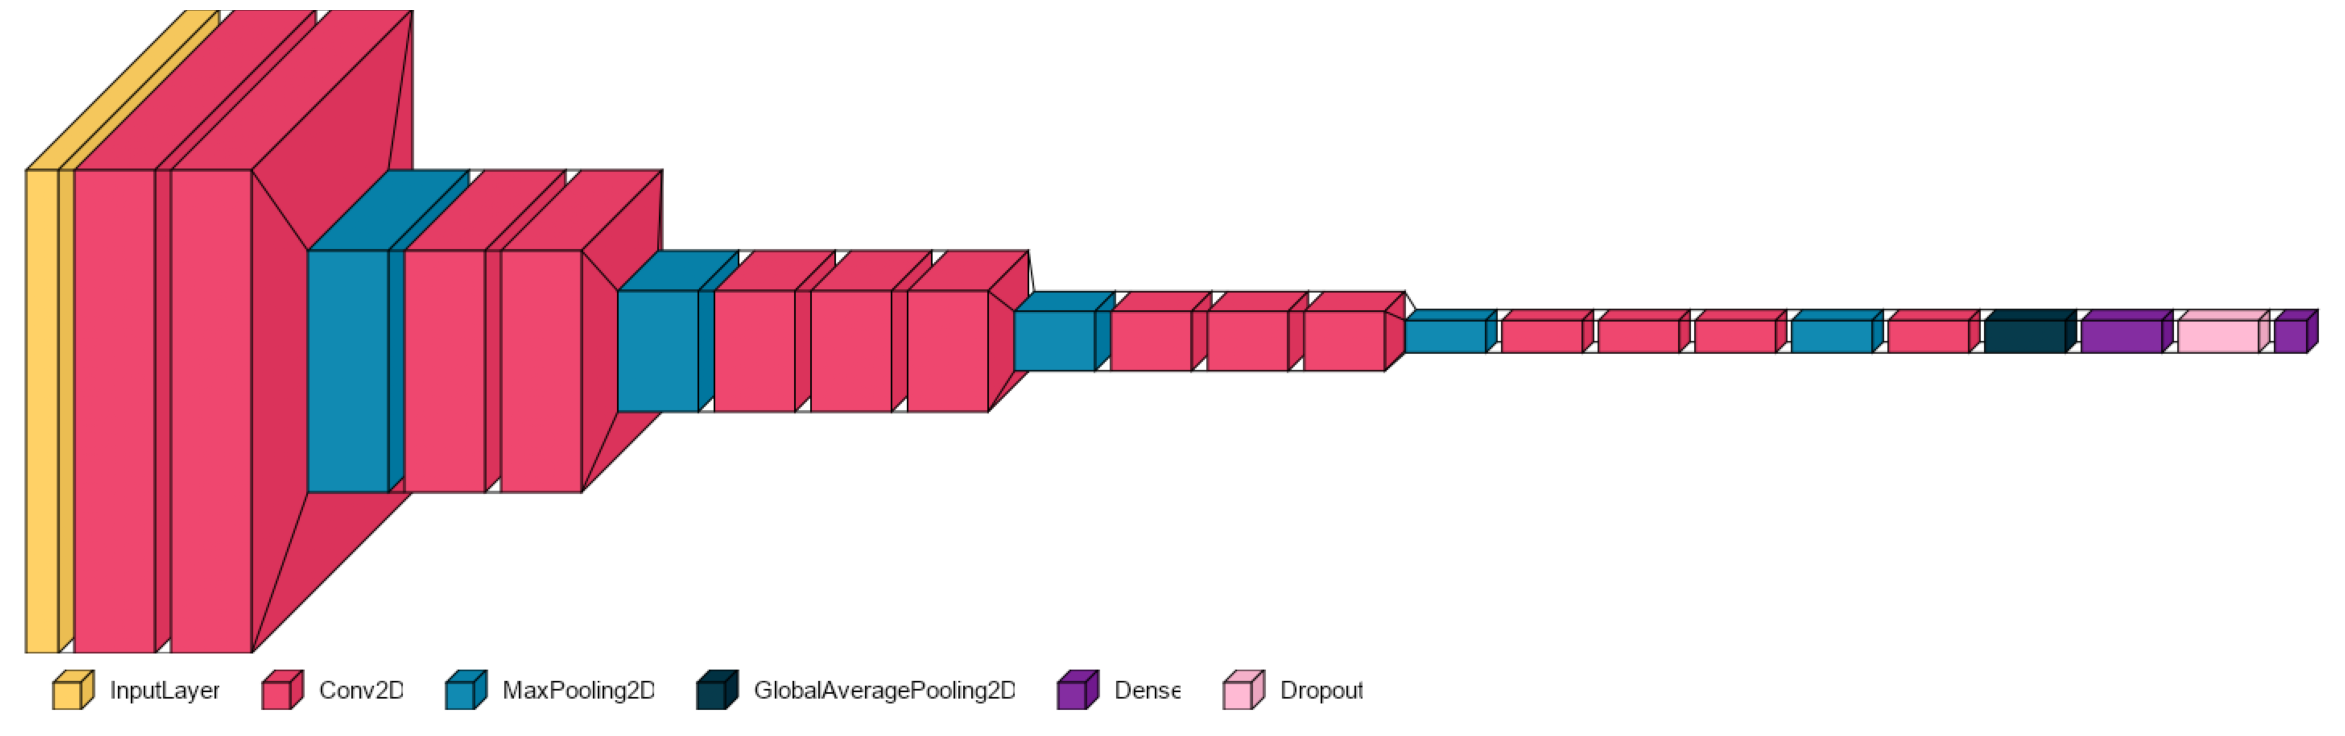

In [15]:
# 5.2.e Visualize the model
font = ImageFont.truetype("arial.ttf", 15)  
visualkeras.layered_view(model_2, to_file='VGG16.png', legend=True, scale_xy=1, scale_z=1,font=font, max_z=50)
# Display the image
plt.figure(figsize=(30,30))
plt.imshow(plt.imread('VGG16.png'))
plt.axis('off')

### 5.3. EFFNET

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4149 - loss: 1.2916
Epoch 1: val_accuracy improved from -inf to 0.67247, saving model to model_3.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4164 - loss: 1.2891 - val_accuracy: 0.6725 - val_loss: 0.7940 - learning_rate: 0.0010
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6949 - loss: 0.7791
Epoch 2: val_accuracy improved from 0.67247 to 0.74216, saving model to model_3.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.6951 - loss: 0.7786 - val_accuracy: 0.7422 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7682 - loss: 0.6432
Epoch 3: val_accuracy improved from 0.74216 to 0.80139, saving model to model_3.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.7681 - loss: 0.6434 - val_accuracy: 0.8014 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7562 - loss: 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,064,945 (15.51 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 10,250 (40.04 KB)

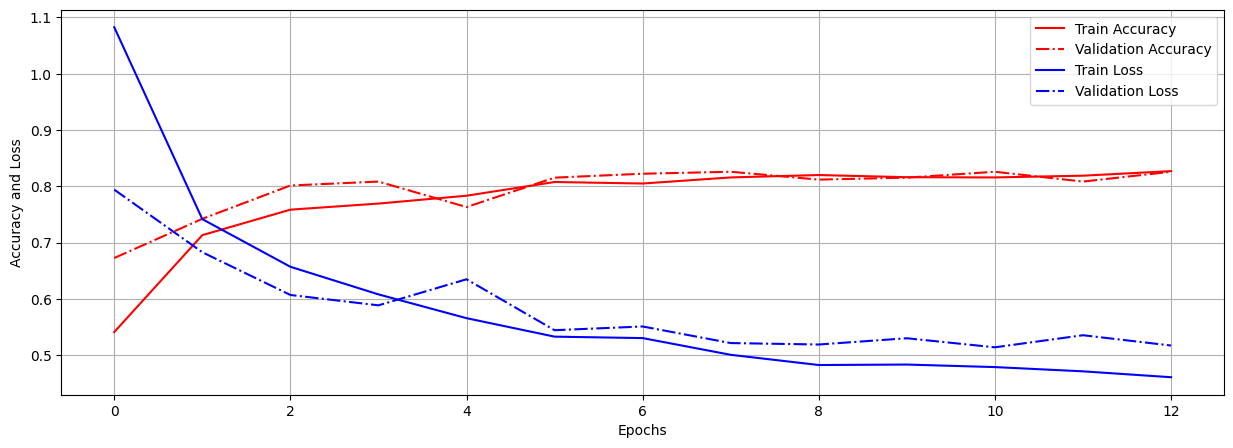

In [16]:
#5.3.a Define a directory to save the model
model_3_dir = 'model_3.keras'
history_3_dir = 'history_3.csv'

# Unnormalize the images for EFFNET (seems EFFNET does not work with normalized images)
X_train_EFFNET = (X_train.copy()*255).astype('float16')
X_val_EFFNET = (X_val.copy()*255).astype('float16')

#5.3.b Define the model by transfer learning model using EFFNET
EFFNET_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

## Make sure the base model is not trainable
EFFNET_base.trainable = False

## Additional layers
model_3 = EFFNET_base.output
model_3 = tf.keras.layers.GlobalAveragePooling2D()(model_3)
model_3 = tf.keras.layers.Dropout(rate=0.5)(model_3)
model_3= tf.keras.layers.Dense(4, activation='softmax')(model_3)
model_3 = tf.keras.models.Model(inputs=EFFNET_base.input, outputs = model_3)

#5.3.c Execute the model
model_3, history_3 = modelEXE(model_3_dir, history_3_dir, model_3, X_train_EFFNET, y_train, X_val_EFFNET, y_val)

#5.3.d Plot the history
plot_history(history_3)
# Discard the variables
del X_train_EFFNET,X_val_EFFNET

(-0.5, 2497.5, 446.5, -0.5)

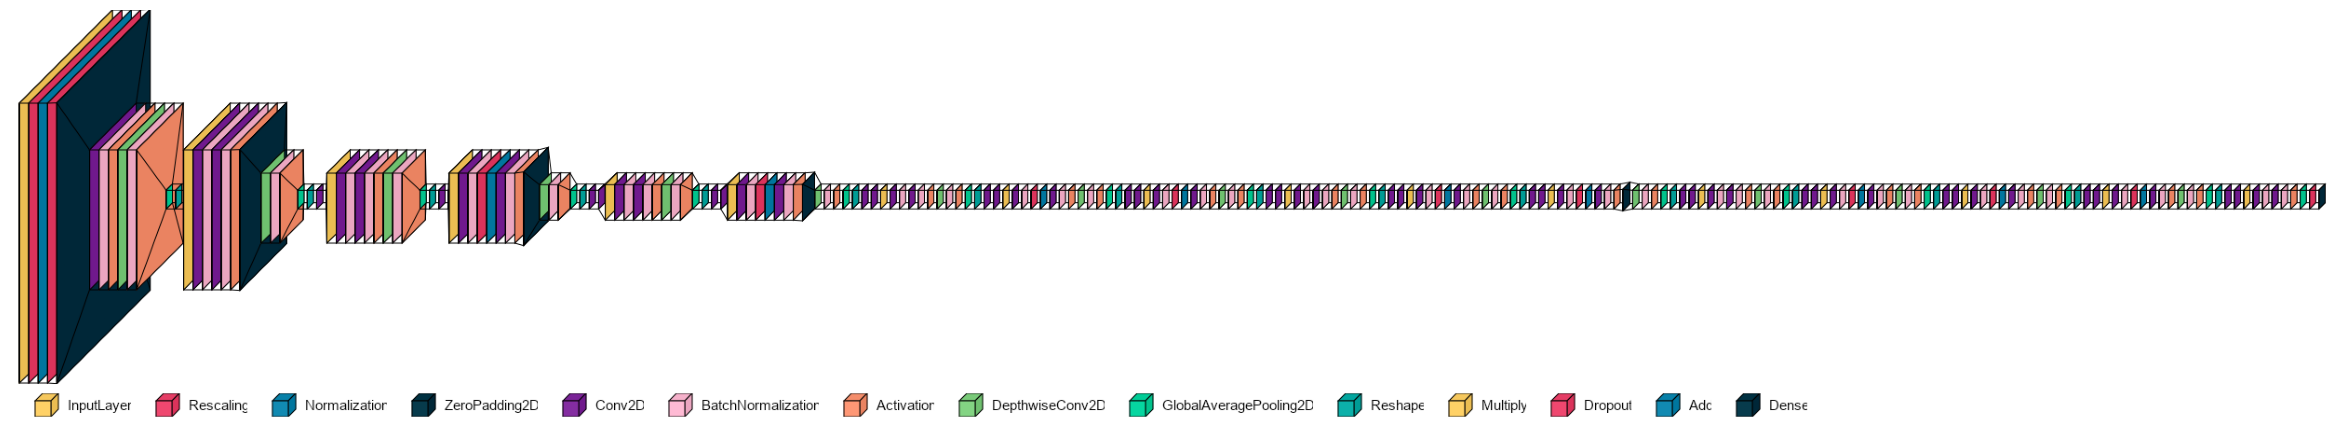

In [17]:
# 5.3.e Visualize the model
font = ImageFont.truetype("arial.ttf",15)  
visualkeras.layered_view(model_3, to_file='EFFNET.png', legend=True, scale_xy=1, scale_z=1, max_z=0.1, font=font)
# Display the image
plt.figure(figsize=(30,30))
plt.imshow(plt.imread('EFFNET.png'))
plt.axis('off')

## 6. Investigation of the Neural network predictions

Next, we investigate the models prediction with the confusion matrix, f1-score and the prediction accuracy calculated from the predicted values and the labels from the validataion dataset.

### 6.1 Predictions on the validation data

In [18]:
# Define a function to construct the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots the confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [19]:
# Obtain the predictions from each model
X_val_EFFNET = (X_val.copy()*255).astype('float16')

y_pred_1 = np.argmax(model_1.predict(X_val), axis=1)
y_pred_2 = np.argmax(model_2.predict(X_val), axis=1)
y_pred_3 = np.argmax(model_3.predict(X_val_EFFNET), axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


Text(0.5, 1.0, 'EFFNET')

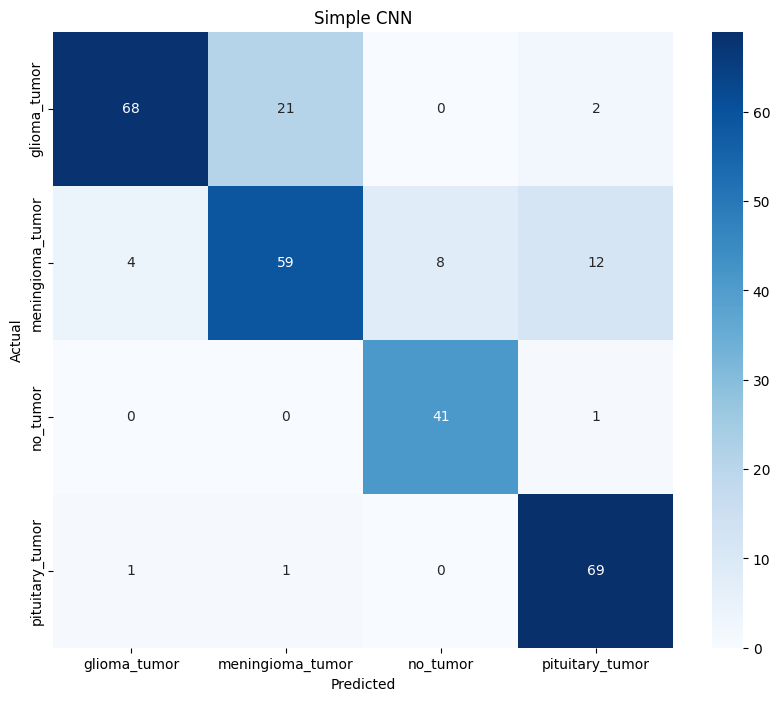

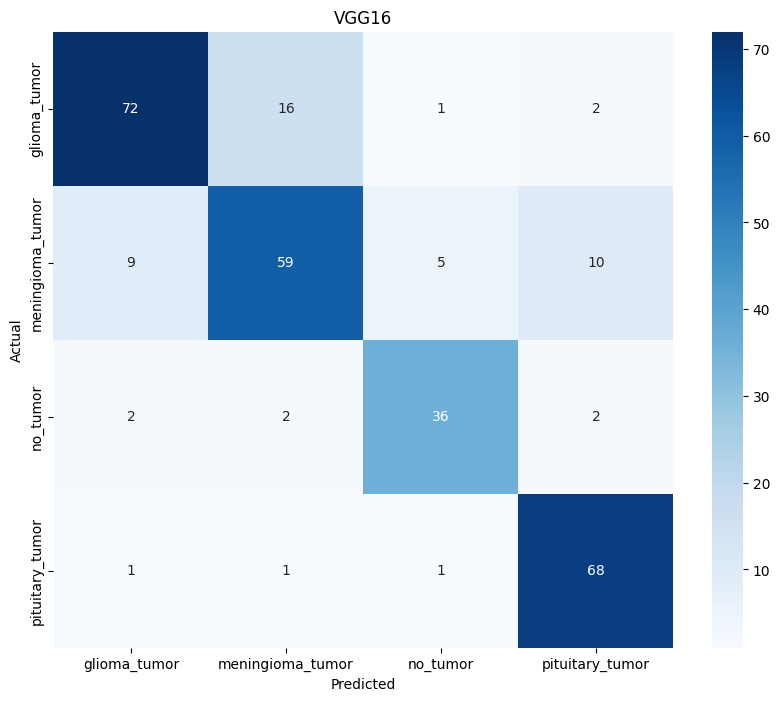

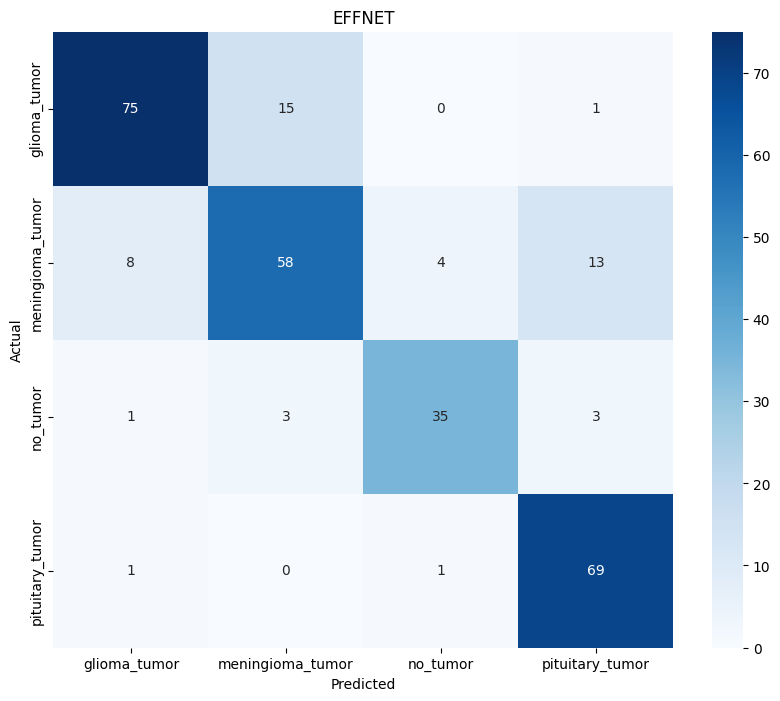

In [20]:
# Plot the confusion matrix in subplots
plot_confusion_matrix(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_1, labels=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.title('Simple CNN')

plot_confusion_matrix(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_2, labels=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.title('VGG16')

plot_confusion_matrix(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_3, labels=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.title('EFFNET')

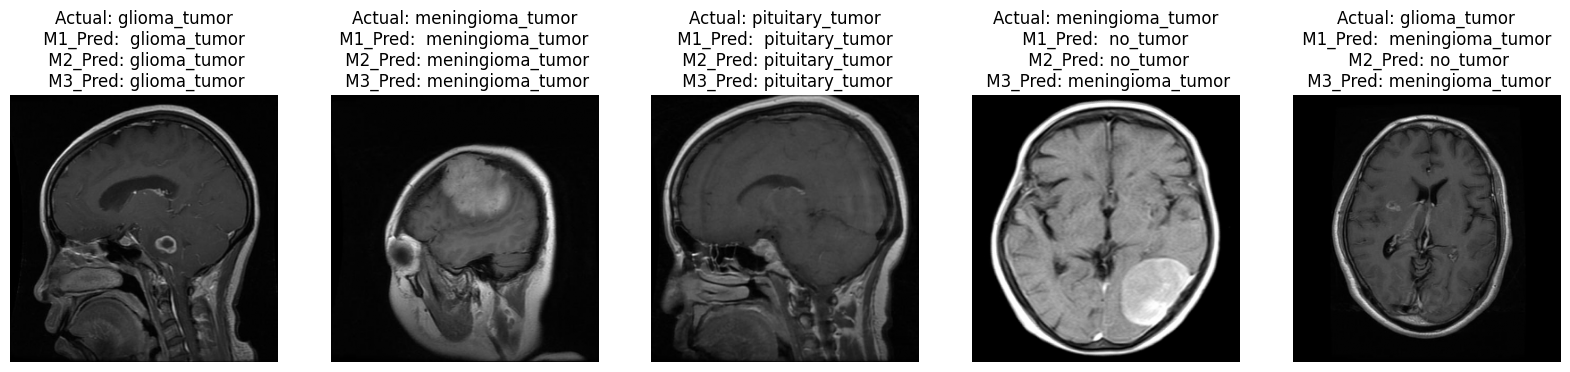

In [21]:
# Display a few images with the predictions
plt.figure(figsize=(20, 10))

# Mapping of numeric predictions to string labels
labels = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

# Apply labels
y_pred_labels_1 = np.array([labels[pred] for pred in y_pred_1])
y_pred_labels_2 = np.array([labels[pred] for pred in y_pred_2])
y_pred_labels_3 = np.array([labels[pred] for pred in y_pred_3])

# Display the images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_val[i])
    plt.title(f"Actual: {y_val[i]}\n M1_Pred:  {y_pred_labels_1[i]} \n M2_Pred: {labels[y_pred_2[i]]}\n M3_Pred: {labels[y_pred_3[i]]}")
    plt.axis('off')

> From the results, it is observed that the models seems working better on side to side (sagittal plane) scan than others, that is top to down (axial plane) and front to back (coronal plane) scan. 

In [22]:
# Calculate the f1 score of each model
from sklearn.metrics import f1_score
f1_1 = f1_score(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_1, average='weighted')
f1_2 = f1_score(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_2, average='weighted')
f1_3 = f1_score(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_3, average='weighted')

print(f"F1 Score of Model 1: {f1_1}")
print(f"F1 Score of Model 2: {f1_2}")
print(f"F1 Score of Model 3: {f1_3} \n"+'-'*50)

# Calculate the accuracy of each model
acc_1 = accuracy_score(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_1)
acc_2 = accuracy_score(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_2)
acc_3 = accuracy_score(np.argmax(pd.get_dummies(y_val).values, axis=1), y_pred_3)

print(f"Accuracy of Model 1: {acc_1}")
print(f"Accuracy of Model 2: {acc_2}")
print(f"Accuracy of Model 3: {acc_3}")


F1 Score of Model 1: 0.8231428010495769
F1 Score of Model 2: 0.8167243199860361
F1 Score of Model 3: 0.8235943524390323 
--------------------------------------------------
Accuracy of Model 1: 0.8257839721254355
Accuracy of Model 2: 0.818815331010453
Accuracy of Model 3: 0.8257839721254355


### 6.2 Predictions on the testing data

The prediction of the 1st layer model on the testing data is also obtained to compare the results with the meta-model.

In [23]:
# Obtain the testing predictions from each model
X_test_EFFNET = (test_img.copy()*255).astype('float16')

y_pred_1_test = np.argmax(model_1.predict(test_img), axis=1)
y_pred_2_test = np.argmax(model_2.predict(test_img), axis=1)
y_pred_3_test = np.argmax(model_3.predict(X_test_EFFNET), axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


Text(0.5, 1.0, 'EFFNET')

<Figure size 2000x500 with 0 Axes>

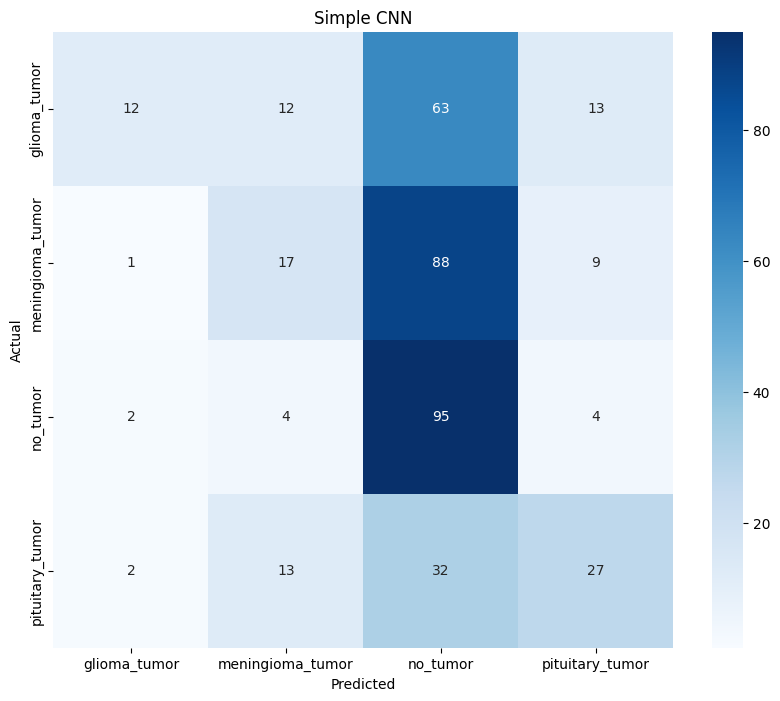

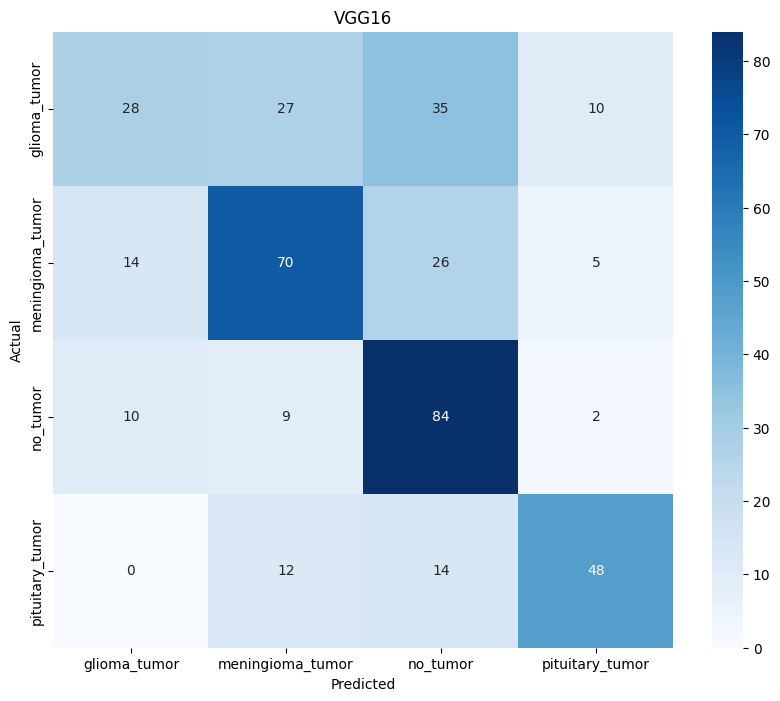

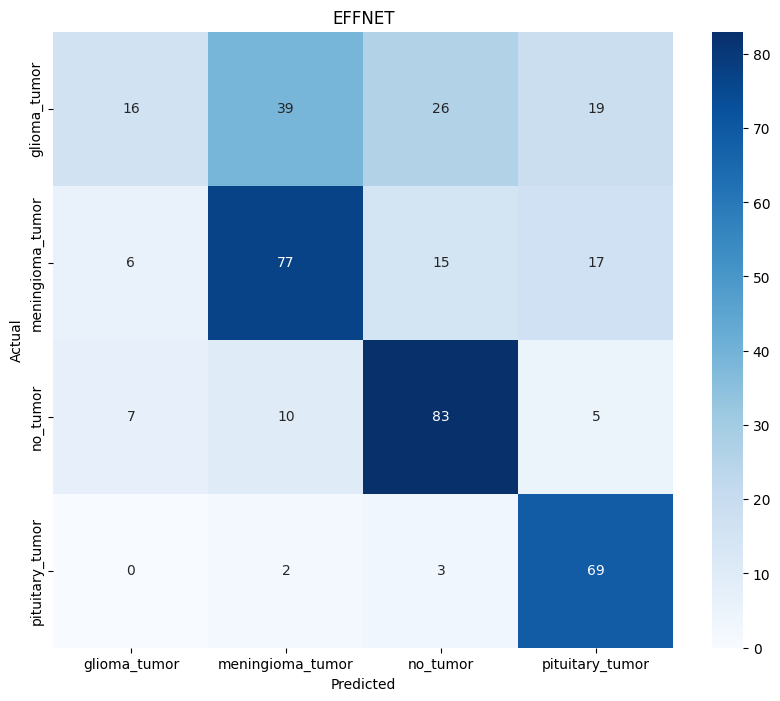

In [24]:
# Plot the confusion matrix in subplots
plt.figure(figsize=(20, 5))
plot_confusion_matrix(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_1_test, labels
=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.title('Simple CNN')

plot_confusion_matrix(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_2_test, labels
=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.title('VGG16')

plot_confusion_matrix(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_3_test, labels
=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.title('EFFNET')

In [25]:
# Calculate the f1 score of each model
f1_1 = f1_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_1_test, average='weighted')
f1_2 = f1_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_2_test, average='weighted')
f1_3 = f1_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_3_test, average='weighted')

print(f"F1 Score of Model 1: {f1_1}")
print(f"F1 Score of Model 2: {f1_2}")
print(f"F1 Score of Model 3: {f1_3} \n"+'-'*50)
# Calculate the testing accuracy of each 1st layer model
acc_1_test = accuracy_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_1_test)
acc_2_test = accuracy_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_2_test)
acc_3_test = accuracy_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_3_test)
# Print the accuracy of each model
print(f"Accuracy of Model 1 on Test data: {acc_1_test}")
print(f"Accuracy of Model 2 on Test data:: {acc_2_test}")
print(f"Accuracy of Model 3 on Test data:: {acc_3_test}")

F1 Score of Model 1: 0.3257661791208672
F1 Score of Model 2: 0.5681901350171481
F1 Score of Model 3: 0.5794826658158101 
--------------------------------------------------
Accuracy of Model 1 on Test data: 0.383248730964467
Accuracy of Model 2 on Test data:: 0.583756345177665
Accuracy of Model 3 on Test data:: 0.6218274111675127


> The accuracy of the 1st layer models prediction on the testing datasets are not very good, while they performed pretty well on the training and validation set. This indicates the models are overfitted to the training set. This is probably due to the dataset contains MRI scans from different orientations, and their distributions in the training and testing data sets are different.

## 7. Meta-model by ensembling the 1st layer model prediction.

After obtaining the predictions from the 1st layer, we can ensemble them to form a meta-model, with a goal to ensemble those weeker learner into a more powerful model. There are different ways in ensembling models, such as bagging, averaging, majority voting and stacking. [1]

We select to stack the 1st layer model with a random forest classifier as the second level model. For stacking, it is better to use out of fold (OoF) predictions from cross-validation datasets to ensemble. However, the computation of the cross-validation is huge and therefore is skipped in this notebook. Without the OoF predictions, the ensemble method will be prone to suffer from data leakage.

Here, we ensemble the 1st layer models by stacking their prediction with a random forest classifier. RandomizedSearchCV is used to optimize the hyperparameters of the meta-model. 

Reference:
<br> [1] http://arxiv.org/abs/2104.02395 

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 50, 'min_samples_leaf': 5, 'max_depth': 10, 'bootstrap': True}
F1 Score of Model 3: 0.5412515209624336 
--------------------------------------------------
Accuracy of Meta Model: 0.5786802030456852


<Figure size 1000x800 with 0 Axes>

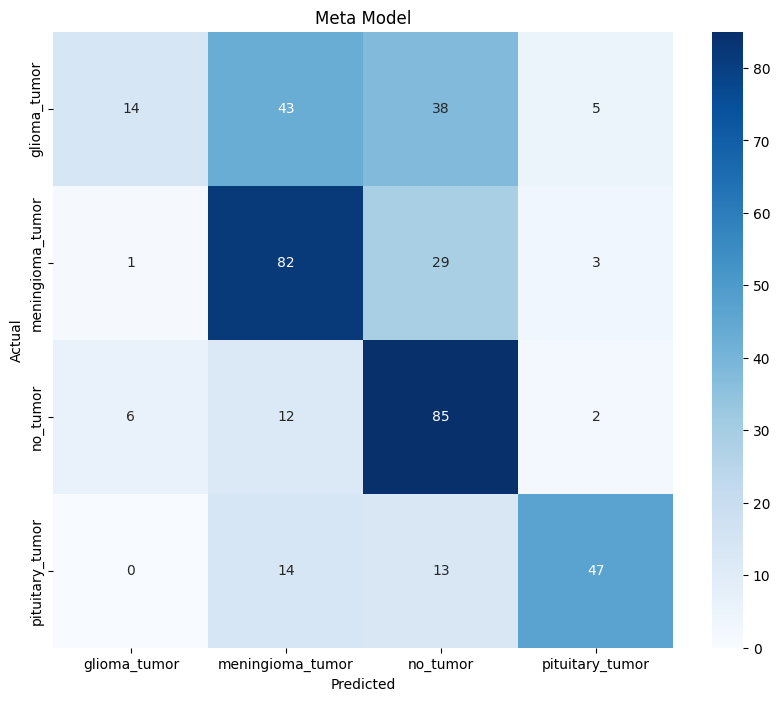

In [26]:
# Ensemble the models into a meta model with a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Define the meta-model directory
meta_model_dir = 'meta_model.pkl'

# Define a if loop to check if the model exists

if not os.path.exists(meta_model_dir):

    # Define the meta model
    meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Define a list of hyperparameters for the meta model

    param = {
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [5, 10, 15, 20, 25, 30],
        'min_samples_leaf': [1, 2, 5, 10, 15],
        'bootstrap': [True, False]
    }

    # Implement a randomized search for the meta-model hyperparameters tuning
    RS_meta_model = RandomizedSearchCV(meta_model, param, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

    # Fit the meta model
    RS_meta_model.fit(np.array([y_pred_1, y_pred_2, y_pred_3]).T, np.argmax(pd.get_dummies(y_val).values, axis=1))

    # Obtain the predictions from the meta model
    y_pred_meta_test = RS_meta_model.predict(np.array([y_pred_1_test, y_pred_2_test, y_pred_3_test]).T)

    # Display the best parameters
    print(f"Best Parameters: {RS_meta_model.best_params_}")

    # Save the meta model
    import joblib
    joblib.dump(RS_meta_model, 'meta_model.pkl')

else:
    # Load the meta model
    RS_meta_model = joblib.load(meta_model_dir)

    # Obtain the predictions from the meta model
    y_pred_meta_test = RS_meta_model.predict(np.array([y_pred_1_test, y_pred_2_test, y_pred_3_test]).T)

# Define the meta model
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Plot the confusion matrix of the meta model
plt.figure(figsize=(10, 8))
plot_confusion_matrix(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_meta_test, labels
=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])
plt.title('Meta Model')

# Calculate the f1-score and accuracy of the meta model
f1_meta = f1_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_meta_test, average='weighted')
acc_meta = accuracy_score(np.argmax(pd.get_dummies(test_labels).values, axis=1), y_pred_meta_test)
print(f"F1 Score of Model 3: {f1_meta} \n"+'-'*50)
print(f"Accuracy of Meta Model: {acc_meta}")

> The prediction accuracy is still not very good. But the meta-model shows better prediction accuracy compared with the simple CNN (model-1).

## 8. Conclusion

In this project, an image classifier for identifying different types of brain cancer is developed. By augmenting the images with rotations, flippings and different sizings, augmented and the original images are used to train 3 different CNN models, with model-1 having a simple architecture developed in this study, and model 2 and 3 using pretrained models, VGG16 and EFFICIENTNETB0 respectively, as the top layer of models for transfer learning. The prediction of the three models are used to train a meta-model, ensembled by feeding the predictions from the 3 1st layer models with a random forest classifier. While the 1st layer models showed good accuracy on the validation set, the accuracy of the prediction on the testing set is not very good for both 1st layer learners and the meta-model (~0.57). Future improvement of the models is required. 

## 9.Future improvements

It is suspected the reduced accuracy of the model prediction on the testing dataset is due to the different orientations of the MRI scans in the data. Also, the images are varied in size and have a lot of unrelated information, such as the skull and other tissues that are unrelated to the classification problem. 

Therefore, we suggest further preprocess the data by:
1. Identifying the different orientations of MRI scan and include the information as a feature;
2. Denoising of images
3. Masking and removing the skull, and allign the images into a given frame. 
4. Edge identification of images, use those image with edges as inputs in a different model, and use both the new and old models to ensemble a meta-model. 

The achitecture of the models are also be futher improved by incluiding: 

1. Hyperparameter tuning of the CNN network [3], such as using AdaptiveBatch size


Ref: 
[1] https://www.youtube.com/watch?v=oXlwWbU8l2o 
[2] https://www.youtube.com/watch?v=gMuxB18Cr0o 
[3] https://doi.org/10.1016/j.dajour.2024.100470. 